In [41]:
using Revise

In [42]:
using PyPlot, Statistics
using ClimateMARGO

In [43]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Utils
include("ebm.jl");

In [44]:
#] add DataFrames, CSV

In [45]:
using DataFrames, CSV

In [46]:
#run(`wget https://raw.githubusercontent.com/hdrake/cmip6-temperature-demo/cmip5_gmst/data/cmip5_rcp85_gmst.csv`)

In [47]:
data_path = "cmip5_rcp85_gmst.csv"
data = DataFrame!(CSV.File(data_path));

years = data[:,2];
gmst = Array(data[:, 3:end]);
gmst[ismissing.(gmst)] .= NaN;

### Stylized Extended RCP8.5 (ECP8.5) scenario

In [37]:
Δt = 1.
initial_year = 1850
final_year = 3000.
t_arr = collect(initial_year:Δt:final_year)

CO2e = zeros(size(t_arr));
q = zeros(size(t_arr));

# Construct CO2e following RCP8.5 until 2100
# https://www.iiasa.ac.at/web-apps/tnt/RcpDb/dsd?Action=htmlpage&page=compare
CO2e[t_arr .<= 2100] = (280. .+ (1350. - 280.) .* exp.((t_arr .- 2100.)/(37.5)))[t_arr .<= 2100];

# Take derivation to estimate q
q[1:size(t_arr[t_arr .<= 2100][1:end-1], 1)] = diff(CO2e[t_arr .<= 2100])/Δt

# Extend according to ECP85 scenario that has emissions linearly decreasing to zero by 2150.
qmax = q[size(t_arr[t_arr .<= 2100][1:end-1], 1)]
q[(t_arr .>= 2100) .& (t_arr .< 2120)] .= qmax
q[t_arr .>= 2120] = (qmax * (1 .- (t_arr .- 2120.)/(2200. - 2120.)))[t_arr .>= 2120]
q[q .< 0.] .= 0.;

params = ClimateMARGO.IO.included_configurations["default"]
params.domain = Domain(Δt, initial_year, initial_year, final_year)
params.economics.baseline_emissions = q/params.physics.r;
params.physics.T0 = 0.;
params.physics.c0 = 280.;
model = ClimateModel(params);

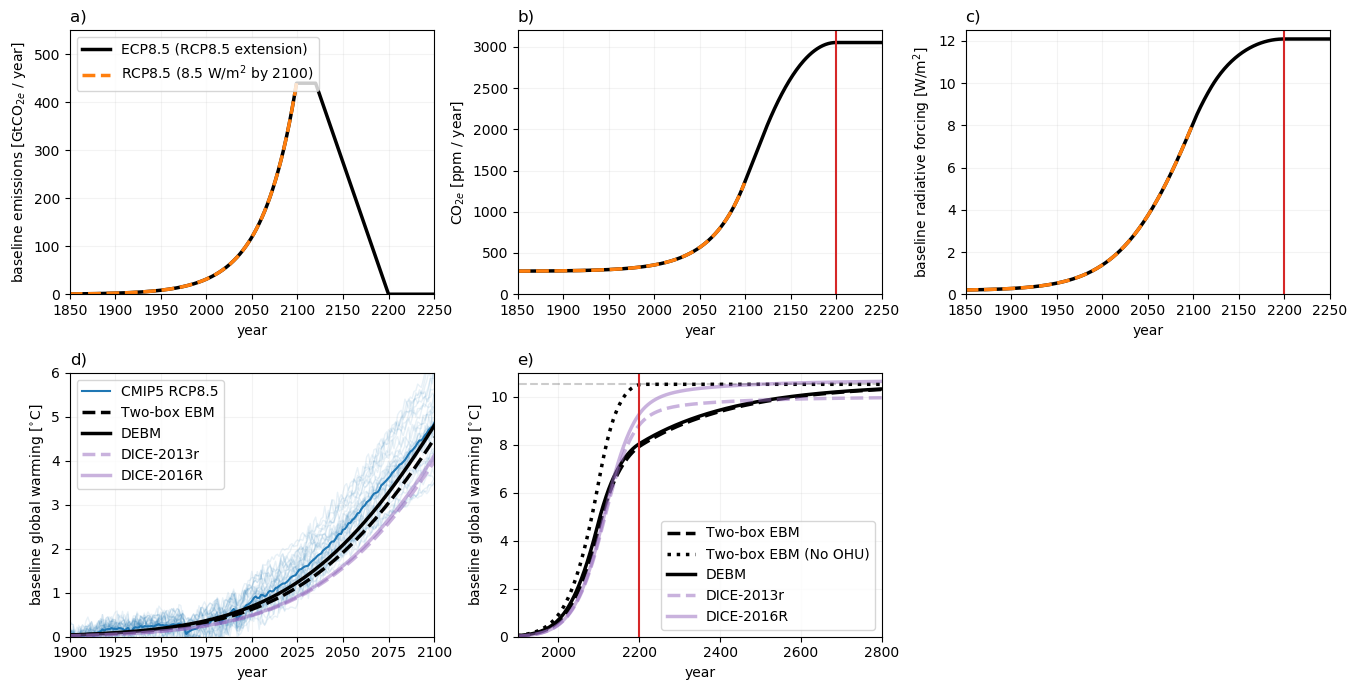

In [49]:
figure(figsize=(13.5,7))

F2x0 = F2x(model)

subplot(2,3,5)
plot(t(model), DICE_EBM(t(model), Δt, F(model), default="Geoffroy-2013"), "k--", lw=2.5, label="Two-box EBM")
plot(t(model), DICE_EBM(t(model), Δt, F(model), default="Geoffroy-NoMixing"), "k:", lw=2.5, label="Two-box EBM (No OHU)")
plot(t(model), T(model), lw=2.5, "k-", label="DEBM")
plot(t(model), DICE_EBM(t(model), Δt, 3.8/F2x0*F(model), default="DICE-2013r"), "C4--", alpha=0.5, lw=2.5, label="DICE-2013r")
plot(t(model), DICE_EBM(t(model), Δt, 3.6813/F2x0*F(model), default="DICE-2016R"), "C4-", alpha=0.5, lw=2.5, label="DICE-2016R")


plot([1850, 3000], maximum(F(model))/model.physics.B*[1,1], "k--", alpha=0.2)

xlim(1900, 2800)
ylim([0, 11.])
plot([2200, 2200], [0, 11], "C3-")
grid(true, alpha=0.15)
legend()
ylabel(L"baseline global warming [$^{\circ}$C]")
xlabel("year")
title("e)", loc="left")

subplot(2,3,4)
for i=1:size(gmst, 2)
    plot(years, gmst[:, i], "C0-", lw=1., alpha=0.1)
end
plot(years, mean(gmst[:, :], dims=2), "C0-")
plot([],[],"C0-", label="CMIP5 RCP8.5")
plot(t(model), DICE_EBM(t(model), Δt, F(model), default="Geoffroy-2013"), "k--", lw=2.5, label="Two-box EBM")
plot(t(model), T(model), lw=2.5, "k-", label="DEBM")
plot(t(model), DICE_EBM(t(model), Δt, F(model)*3.8/F2x0, default="DICE-2013r"), "C4--", lw=2.5, alpha=0.5, label="DICE-2013r")
plot(t(model), DICE_EBM(t(model), Δt, F(model)*3.6813/F2x0, default="DICE-2016R"), "C4-", lw=2.5, alpha=0.5, label="DICE-2016R")
xlim(1900, 2100)
ylim([0, 6.])
grid(true, alpha=0.15)
legend()
ylabel(L"baseline global warming [$^{\circ}$C]")
xlabel("year")
title("d)", loc="left")

subplot(2,3,3)
plot(t(model), F(model) .+ 0.2, lw=2.5, "k-")
plot(t(model)[t(model) .< 2100], F(model)[t(model) .< 2100] .+ 0.2, lw=2.5, "C1--")
plot([2200, 2200], [0, 14.], "C3-")
ylim([0., 12.5])
xlim(1850, 2250)
grid(true, alpha=0.15)
ylabel(L"baseline radiative forcing [W/m$^{2}$]")
xlabel("year")
title("c)", loc="left")

subplot(2,3,2)
plot(t(model), c(model), lw=2.5, "k-")
plot(t(model)[t(model) .< 2100], c(model)[t(model) .< 2100], lw=2.5, "C1--")
plot([2200, 2200], [0, 3200.], "C3-")
ylim([0., 3200.])
xlim(1850, 2250)
grid(true, alpha=0.15)
ylabel(L"CO$_{2e}$ [ppm / year]")
xlabel("year")
title("b)", loc="left")
ppm_to_GtCO2
subplot(2,3,1)
plot(t(model), ppm_to_GtCO2(model.economics.baseline_emissions), "k-", label="ECP8.5 (RCP8.5 extension)", lw=2.5)
plot(t(model)[t(model) .< 2100], ppm_to_GtCO2(model.economics.baseline_emissions)[t(model).< 2100], "C1--", lw=2.5, label=L"RCP8.5 (8.5 W/m$^{2}$ by 2100)")
ylim([0, 550])
xlim(1850, 2250)
grid(true, alpha=0.15)
legend(loc="upper left")
ylabel(L"baseline emissions [GtCO$_{2e}$ / year]")
xlabel("year")
title("a)", loc="left")

tight_layout()
savefig("figures/MARGO_CMIP5_validation.png", dpi=200, bbox_inches="tight")